## Electricty Usage in Site Eagle
Try forecast electricy usage in one building in site Eagle


In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='C:/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
ELECT_FILE='electricity.csv'
WEATHER_FILE='weather.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed
def get_site_timeseries(panda,site):
    # Assume the panda dataframe has a datetime column.
    # (If not, call fix_date_type() before this.)
    # Extract the timeseries for one site.
    # Convert the datetime column to a DatetimeIndex.
    site_df = panda[panda['site_id']==site]
    temp_col = site_df['date']
    temp_val = temp_col.values
    temp_ndx = pd.DatetimeIndex(temp_val)
    dropped = site_df.drop('date',axis=1)
    panda = dropped.set_index(temp_ndx)
    return panda

In [4]:
SITE = 'Eagle'
METER = 'Electricty'
BLDG = 'Eagle_education_Peter'
wet_df = read_zip_to_panda(ZIP_PATH,WEATHER_FILE)
wet_df = fix_date_type(wet_df)
elec_df = read_zip_to_panda(ZIP_PATH,ELECT_FILE)
elec_df = fix_date_type(elec_df)
site_specific_weather = wet_df.loc[wet_df['site_id'] == SITE]
bldg_specific_elect = elec_df[[BLDG]]
#print(site_specific_weather.info())
#print(bldg_specific_electricity.info())  

In [5]:
one_bldg_df = pd.concat([bldg_specific_elect,site_specific_weather],axis=1)
one_bldg_df = one_bldg_df.drop(['site_id'],axis=1)
one_bldg_df = one_bldg_df.rename(columns={BLDG : METER})

print("Note 17544 rows = two years hourly, including one leap day.")
print("Note every column contains some NaN:")
one_bldg_df.info()

Note 17544 rows = two years hourly, including one leap day.
Note every column contains some NaN:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Electricty      17544 non-null  float64
 1   airTemperature  17533 non-null  float64
 2   cloudCoverage   10528 non-null  float64
 3   dewTemperature  17533 non-null  float64
 4   precipDepth1HR  17440 non-null  float64
 5   precipDepth6HR  645 non-null    float64
 6   seaLvlPressure  17329 non-null  float64
 7   windDirection   17010 non-null  float64
 8   windSpeed       17498 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [6]:
one_bldg_df.corr()

,Electricty,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
Electricty,1.000000,0.103883,-0.008615,0.004470,0.018163,0.071491,-0.064867,-0.015119,0.072154
airTemperature,0.103883,1.000000,0.043396,0.891414,0.017739,0.120503,-0.247301,-0.054579,-0.028391
cloudCoverage,-0.008615,0.043396,1.000000,0.115785,0.061365,0.030444,-0.203509,-0.066536,0.085135
dewTemperature,0.004470,0.891414,0.115785,1.000000,0.084074,0.215176,-0.308613,-0.184510,-0.152528
precipDepth1HR,0.018163,0.017739,0.061365,0.084074,1.000000,0.508912,-0.113506,-0.049742,0.053514
precipDepth6HR,0.071491,0.120503,0.030444,0.215176,0.508912,1.000000,-0.222913,-0.104992,0.009770
seaLvlPressure,-0.064867,-0.247301,-0.203509,-0.308613,-0.113506,-0.222913,1.000000,-0.074461,-0.228705
windDirection,-0.015119,-0.054579,-0.066536,-0.184510,-0.049742,-0.104992,-0.074461,1.000000,0.398483
windSpeed,0.072154,-0.028391,0.085135,-0.152528,0.053514,0.009770,-0.228705,0.398483,1.000000


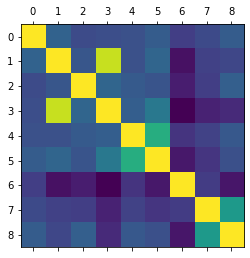

In [7]:
plt.matshow(one_bldg_df.corr())
plt.show()

In [8]:
# Linear Regression
X = one_bldg_df.drop(METER,axis=1).fillna(0)
y = one_bldg_df[METER].fillna(0)
split = 900
X_train = X.iloc[0:split]
y_train = y.iloc[0:split]
linreg = LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression()

In [9]:
# Cross validation.
# For now, just test an arbitrary group.
X_test = X.iloc[split:]
y_test = y.iloc[split:]
y_pred = linreg.predict(X_test)
rmse = mean_squared_error(y_test,y_pred,squared=False)
print("RMSE = std dev of unexplained variation:",rmse)

RMSE = std dev of unexplained variation: 250.86155759208037


In [10]:
print("std dev of the response variable:",y_test.std())
y_test.describe()

std dev of the response variable: 214.2763664822777


count    16644.000000
mean      1539.121325
std        214.276366
min          0.000000
25%       1437.507725
50%       1511.177400
75%       1654.528700
max       1989.069500
Name: Electricty, dtype: float64